# Demystifying PyTorch WeightedRandomSampler by example

by Chris Hughes

Recently, I found myself in the familiar situation of working with a vastly unbalanced dataset, which was impacting the training of my CNN model on a computer vision task. Whilst there are various ways of approaching this, the findings of a study into handling class imbalance when training CNN models on different datasets concluded that, in almost all cases, the best strategy was oversampling the minority class(es); increasing the frequency that images from these classes are seen by the model during training.

However, whilst the idea seems simple enough, implementing this in PyTorch usually involves interacting with the somewhat enigmatic WeightedRandomSampler. The documentation for WeightedRandomSampler is quite scarce, both with regards to how it works, and how to set the parameters to ensure that it behaves as we would expect. Despite having used this many times in the past, when returning to use it after a long absence, I have often found myself trawling through various forum and StackOverflow posts to ensure that I am setting it correctly. Whilst there is a [great blog post which provides a mathematically rigorous breakdown of how it is implemented behind the scenes](https://medium.com/r?url=https%3A%2F%2Ftowardsdatascience.com%2Faddress-class-imbalance-easily-with-pytorch-bb540497d2a6), as we humans are often notoriously poor at understanding probability theory, it can be difficult to gain an intuition from this alone.

In this article, I shall take a pragmatic approach to understanding the behaviour of WeightedRandomSampler, with the aim of answering the following questions:

- How do I calculate the weights that will be used to balance my dataset?
- As this approach is based on probability, can I be certain that this will balance the dataset in the way that I want?
- Will all of my dataset will be seen during training?
- What if I don't want to balance the dataset evenly, but achieve some other ratio?

We shall do this by interacting with the WeightedRandomSampler object in the context of dealing with a real-world dataset, before running a simple experiment to determine whether balancing the dataset results in any performance improvements for our simple problem.

## Creating an imbalanced dataset

First, let's download some data to use as an example. Here, I am using the Oxford Pets dataset, which contains 37 different categories of cats and dogs. On Linux, we can download this with the following commands:

In [6]:
!wget https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz -P data/pets

--2022-08-23 19:00:06--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/octet-stream]
Saving to: ‘data/pets/images.tar.gz’

images.tar.gz       100%[===================>] 755.23M   138MB/s    in 5.1s    

2022-08-23 19:00:11 (149 MB/s) - ‘data/pets/images.tar.gz’ saved [791918971/791918971]



In [10]:
!ls data/pets

images.tar.gz


In [19]:
!tar -xzf data/pets/images.tar.gz -C data/pets

In [22]:
!rm data/pets/images.tar.gz

Now that we have some data, I often find that a good way of exploring this is by creating a pandas DataFrame. We can use pathlib from the standard library to quickly get a list of all image paths and, as the class names are contained in each file name, we can extract these as part of the same step.

In [2]:
from pathlib import Path

data_path = Path('data/pets/images')

In [3]:
images = []
labels = []

for p in data_path.glob('*.jpg'):
    image_name = p.parts[-1]
    images.append(image_name)
    labels.append('_'.join(image_name.split('_')[0:-1]))
    

We can now use these to easily create a DataFrame, which we can use to quickly inspect the distribution of our labels:

In [4]:
import pandas as pd

df = pd.DataFrame(data={'image': images, 'label': labels})
df.head()

,image,label
0,newfoundland_200.jpg,newfoundland
1,chihuahua_56.jpg,chihuahua
2,Abyssinian_31.jpg,Abyssinian
3,newfoundland_195.jpg,newfoundland
4,staffordshire_bull_terrier_74.jpg,staffordshire_bull_terrier


In [5]:
df.label.value_counts()

newfoundland                  200
chihuahua                     200
shiba_inu                     200
Persian                       200
Bombay                        200
Siamese                       200
beagle                        200
saint_bernard                 200
Ragdoll                       200
miniature_pinscher            200
yorkshire_terrier             200
basset_hound                  200
Bengal                        200
german_shorthaired            200
Egyptian_Mau                  200
keeshond                      200
Maine_Coon                    200
Russian_Blue                  200
Sphynx                        200
boxer                         200
leonberger                    200
Abyssinian                    200
pug                           200
samoyed                       200
japanese_chin                 200
wheaten_terrier               200
British_Shorthair             200
havanese                      200
american_bulldog              200
pomeranian    

From this, we can see that the dataset is well balanced, with almost all classes having around 200 images. Whilst this would usually be a good thing, to make the dataset suitable for our purposes, we can define a function to extract an imbalanced subset of this:

In [6]:
from pathlib import Path

import pandas as pd
from sklearn.model_selection import train_test_split

def create_dfs(data_path, majority_class_name, minority_class_name, num_minority_class):
    data_path = Path(data_path)
    images = []
    labels = []

    for p in data_path.glob("*.jpg"):
        image_name = p.parts[-1]
        images.append(image_name)
        labels.append("_".join(image_name.split("_")[0:-1]))

    df = pd.DataFrame(data={"image": images, "label": labels})
    sample_df = df.query(f'label == "{majority_class_name}" or label == "{minority_class_name}"')
    train_df, val_df = train_test_split(
        sample_df, stratify=sample_df.label, train_size=0.8, random_state=42
    )
    keep_images = set(train_df.query(f'label == "{minority_class_name}"').image.head(num_minority_class).tolist())
    imbalanced_train_df = train_df[
        (train_df.image.isin(keep_images)) | (train_df.label == f"{majority_class_name}")
    ]

    return imbalanced_train_df, val_df

Selecting two of the categories, we can use this to create our imbalanced dataset, as demonstrated below:

In [7]:
imbalanced_train_df, val_df = create_dfs(data_path,
                                         "Siamese",
                                         "Birman",
                                         num_minority_class=10)

print('Train distribution')
print(imbalanced_train_df.label.value_counts())
print('==============')
print('Validation distribution')

val_df.label.value_counts()

Train distribution
Siamese    160
Birman      10
Name: label, dtype: int64
Validation distribution


Birman     40
Siamese    40
Name: label, dtype: int64

Let's encode our class labels with integer values and create a lookup to use in our datasets

In [9]:
label_to_id = {v: idx for idx, v in
               enumerate(imbalanced_train_df.label.unique())}; label_to_id

{'Siamese': 0, 'Birman': 1}

Here, I chose the Siamese and Birman breeds of cat, as they have a passing similarity based on the preview images on the dataset website. We can confirm this by randomly inspecting some of the images.

In [10]:
from PIL import Image

def show_image(row):
    print(row.label)
    return Image.open(data_path/row.image)

Siamese


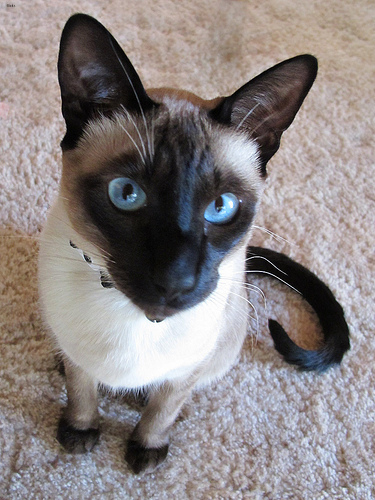

In [11]:
show_image(imbalanced_train_df.iloc[0])

Birman


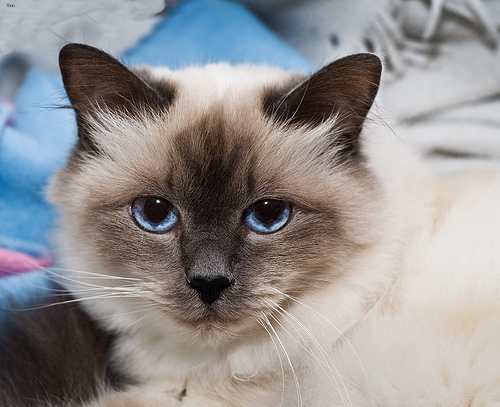

In [12]:
show_image(imbalanced_train_df.iloc[7])

Based on this, these classes seem to be a suitable choice for a simple, but non-trivial task.

## Visualising batch distributions

Now that we have defined our dataset, let's explore the effects of the class imbalance by inspecting the distribution of each batch that the model will see during a single training epoch.
As we do not need to load the images at this point, lets create a tensor dataset from the labels and the index of each image so that we can iterate through this quickly.

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

ds = TensorDataset(torch.as_tensor([(idx, label_to_id[l]) for idx, l in enumerate(imbalanced_train_df.label.values)]))
dl = DataLoader(ds, shuffle=True, batch_size=10)

We can define a function which does this, by keeping track of the classes and indexes seen during each batch and plotting these, as seen below:

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def visualise_dataloader(dl, id_to_label=None, with_outputs=True):
    
    total_num_images = len(dl.dataset)
    idxs_seen = []
    class_0_batch_counts = []
    class_1_batch_counts = []
    
    
    for i, batch in enumerate(dl):
        
        idxs = batch[0][:, 0].tolist()
        classes = batch[0][:, 1]
        class_ids, class_counts = classes.unique(return_counts=True)
        class_ids = set(class_ids.tolist())
        class_counts = class_counts.tolist()

        idxs_seen.extend(idxs)

        if len(class_ids) == 2:
            class_0_batch_counts.append(class_counts[0])
            class_1_batch_counts.append(class_counts[1])
        elif len(class_ids) == 1 and 0 in class_ids:
            class_0_batch_counts.append(class_counts[0])
            class_1_batch_counts.append(0)
        elif len(class_ids) == 1 and 1 in class_ids:
            class_0_batch_counts.append(0)
            class_1_batch_counts.append(class_counts[0])   
        else:
            raise ValueError('More than two classes detected')
            
    if with_outputs:
        
        fig, ax = plt.subplots(1, figsize=(15, 15))

        ind = np.arange(len(class_0_batch_counts))
        width = 0.35  
    
        ax.bar(ind, class_0_batch_counts, width, label=(id_to_label[0] if id_to_label is not None else '0'))
        ax.bar(ind + width, class_1_batch_counts, width, label=(id_to_label[1] if id_to_label is not None else '1'))
        ax.set_xticks(ind, ind+1)
        ax.set_xlabel('Batch index', fontsize=12)
        ax.set_ylabel('No. of images in batch', fontsize=12)
        ax.set_aspect('equal')
    
        plt.legend()
        plt.show()
        
        num_images_seen = len(idxs_seen)
        
        print(f'Avg Proportion of {(id_to_label[0] if id_to_label is not None else "Class 0")} per batch: {(np.array(class_0_batch_counts)/10).mean()}')
        print(f'Avg Proportion of {(id_to_label[1] if id_to_label is not None else "Class 1")} per batch: {(np.array(class_1_batch_counts)/10).mean()}')
        print('=============')
        print(f'Num. unique images seen: {len(set(idxs_seen))}/{total_num_images}')
    return class_0_batch_counts, class_1_batch_counts, idxs_seen
    
    

We can now use this to explore how our data looks.

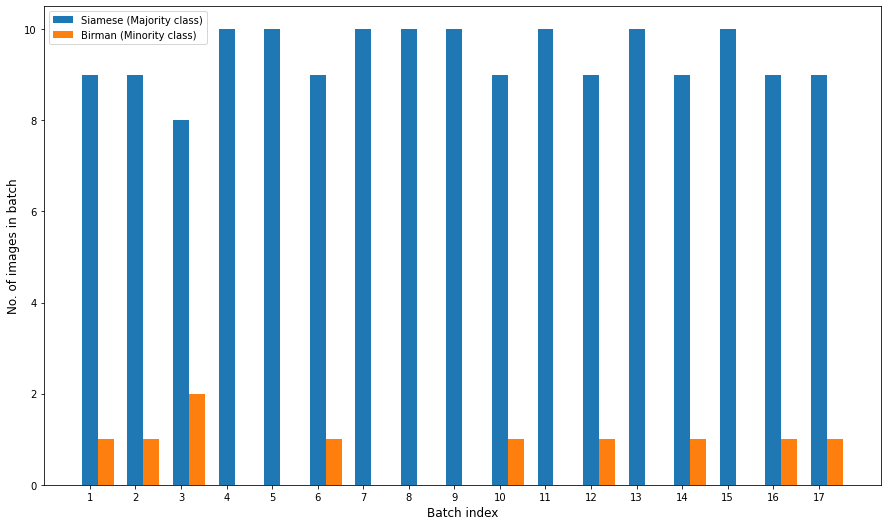

Avg Proportion of Siamese (Majority class) per batch: 0.9411764705882353
Avg Proportion of Birman (Minority class) per batch: 0.05882352941176472
Num. unique images seen: 170/170


In [17]:
class_0_batch_counts, class_1_batch_counts, idxs_seen = visualise_dataloader(dl, 
                                                                             {0: "Siamese (Majority class)",
                                                                              1: "Birman (Minority class)"})

From this, we can clearly observe the effects of the imbalance, as some batches don't contain any images from our minority class at all! Additionally, we can see that every image in our dataset would been seen during training. When we take the average representation across all batches, we observe the same proportions as in our dataset, which is as we would expect.

In [18]:
imbalanced_train_df.label.value_counts(normalize=True)

Siamese    0.941176
Birman     0.058824
Name: label, dtype: float64

## Balancing our dataset with WeightedRandomSampler

Now, let's look at how we can balance our dataset using WeightedRandomSampler. 
The first thing that we need to do is to calculate the weights that will be used to sample each image; from the docs, we can see that we need a weight for each image in the dataset. In my opinion, the most confusing part about this is that these weights do not have to sum to 1. In reality, these weights represent the probability that an image will be selected, PyTorch simply scales these into [0, 1] range behind the scenes for convenience. 

Now that we understand what we need, let's look at how we can calculate these weights. First, we need to calculate how many images belong to each of our classes, using Pandas we can do this as demonstrated below:

In [15]:
class_counts = imbalanced_train_df.label.value_counts(); class_counts

Siamese    160
Birman      10
Name: label, dtype: int64

Now, that we have our class counts, we can calculate the weight for each class by taking the reciprocal of the count. This will ensure that classes with a higher representation will have a smaller weight.

In [16]:
class_weights = 1/class_counts; class_weights

Siamese    0.00625
Birman     0.10000
Name: label, dtype: float64

Now, we simply need to assign the appropriate weight to each sample based on its class. In practice, we can do this directly from the class counts, as demonstrated below:

In [17]:
sample_weights = [1/class_counts[i] for i in imbalanced_train_df.label.values]; sample_weights[:5]

[0.00625, 0.00625, 0.1, 0.1, 0.1]

Next, we can create our sampler and DataLoader:

In [18]:
from torch.utils.data import WeightedRandomSampler

sampler= WeightedRandomSampler(weights=sample_weights, num_samples=len(ds), replacement=True)
dl = DataLoader(ds, sampler=sampler, batch_size=10)

Here, we can see that we have provided our calculated sample weights as an argument and set replacement as True; without this, we would not be able to oversample at all. For now, we have just set the number of samples as the length of our dataset, but we will discuss this more later.
Once again, we can visualise the distribution of our DataLoader batches, this time using WeightedRandomSampler .

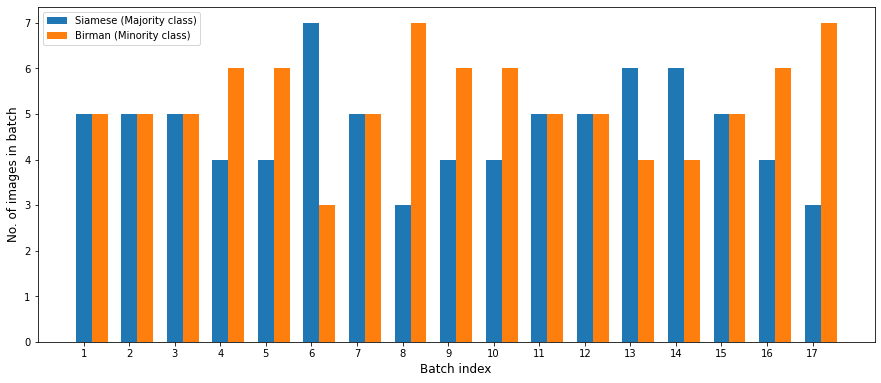

Avg Proportion of Siamese (Majority class) per batch: 0.47058823529411764
Avg Proportion of Birman (Minority class) per batch: 0.5294117647058824
Num. unique images seen: 73/170


In [31]:
class_0_batch_counts, class_1_batch_counts, idxs_seen = visualise_dataloader(dl,
                                                                             {0: "Siamese (Majority class)",
                                                                              1: "Birman (Minority class)"})

From this, we can see that our batches are quite well balanced! Looking at the number of images seen, we can see that the sampler has done this by oversampling the minority class and undersampling the majority class.

To understand which images are being selected in more detail, we can create a DataFrame containing the number of times that each image was seen during this epoch.

In [32]:
from collections import Counter

image_counts_df = (
    pd.merge(
        imbalanced_train_df.reset_index(drop=True)
        .reset_index()
        .rename(columns={"index": "image_idx"}),
        pd.DataFrame.from_records(
            {"image_idx": k, "seen_count": v} for k, v in Counter(idxs_seen).items()
        ),
        how="left",
    )
    .fillna(0)
    .sort_values("seen_count", ascending=False)
    .reset_index(drop=True)
)


In [33]:
image_counts_df.query('label == "Birman"')

,image_idx,image,label,seen_count
0,7,Birman_153.jpg,Birman,13.0
1,9,Birman_54.jpg,Birman,11.0
2,12,Birman_173.jpg,Birman,11.0
3,2,Birman_95.jpg,Birman,10.0
4,15,Birman_135.jpg,Birman,9.0
5,8,Birman_100.jpg,Birman,9.0
6,13,Birman_110.jpg,Birman,9.0
7,16,Birman_87.jpg,Birman,8.0
8,3,Birman_123.jpg,Birman,5.0
9,4,Birman_86.jpg,Birman,5.0


To make this data easier to interpret, we can represent this as an Empirical cumulative distribution function plot, using the snippet below:

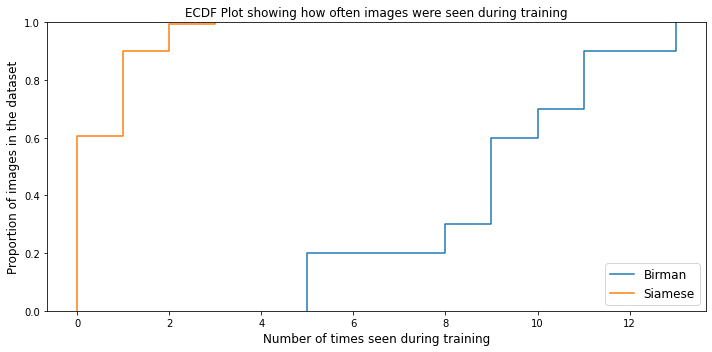

In [34]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 5))
sns.ecdfplot(image_counts_df.query('label == "Birman"').seen_count, ax=ax, label='Birman')
sns.ecdfplot(image_counts_df.query('label == "Siamese"').seen_count, ax=ax, label='Siamese')
ax.set_xlabel('Number of times seen during training', fontsize=12)
ax.set_ylabel('Proportion of images in the dataset', fontsize=12)
ax.legend(fontsize=12)
ax.set_title('ECDF Plot showing how often images were seen during training')
fig.tight_layout()
fig.show()

From this, we can see that to achieve our desired proportion, each image in our minority class was seen at least 5 times, with some as many as 13 times! In contrast, many of the images from our majority class were not seen at all!
You may note that it seems odd that some images from our majority class were seen multiple times whilst others were not seen at all, which does not seem ideal. 

Unfortunately, this is a trade off with a probabilistic based sampling method. Whilst we could set our WeightedRandomSampler to sample without replacement, this would also prevent us from oversampling; so is not useful to us here!

The next logical question to ask is can we ensure that every image is seen during a training run.

## When will all of my images be seen during training?

### Adjusting the number of samples per epoch

As seen above, 97 of the images from our majority class would not have been seen during the training epoch. The reason for this due to the num_samples argument that we defined when we created our WeightedRandomSampler instance. As we specified the number of samples to be the equal to the total number of images in our original, unbalanced, dataset, it makes sense that our sampler will have to ignore some images in order to oversample our minority class. 

Adjusting this parameter to double the size of our original dataset, we can see that more of our images are seen over the course of an epoch.

In [92]:
sampler= WeightedRandomSampler(weights=class_weights, num_samples=int(2*len(ds)))
dl = DataLoader(ds, sampler=sampler, batch_size=10)

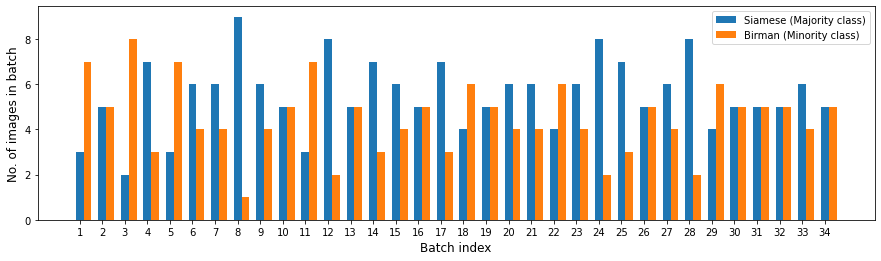

Avg Proportion of Siamese (Majority class) per batch: 0.5529411764705883
Avg Proportion of Birman (Minority class) per batch: 0.4470588235294118
Num. unique images seen: 118/170


In [95]:
class_0_batch_counts, class_1_batch_counts, idxs_seen = visualise_dataloader(dl,
                                                                             {0: "Siamese (Majority class)",
                                                                              1: "Birman (Minority class)"})

However, this does introduce some confusion into what exactly an epoch represents. In Machine Learning, we define an epoch as a single pass through the entire dataset. When each sample is seen only once, this definition makes it very clear to understand exactly what the model has seen up to the current point in training; this becomes less clear when images are being sampled with varying frequencies.

As the notion of an epoch is largely to help us track progress during a training run and has no bearing on the model itself - which just sees a constant stream of images - I prefer to leave the num_samples set to the length of the dataset and trust that all images will be seen at some point as we train for more epochs.

### How many epochs will it take before the model has seen all images?

Resetting our sampler back to its original parameters:

In [ ]:
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(ds), replacement=True)
dl = DataLoader(ds, sampler=sampler, batch_size=10)

let's explore how long it takes for all of our dataset to be seen during a training run. 
To do this, we can set up a simple experiment, where we keep track of all images seen over the course of multiple epochs and plot the number of unique images that have been so far by the end of each epoch. We can do this using the following snippet:

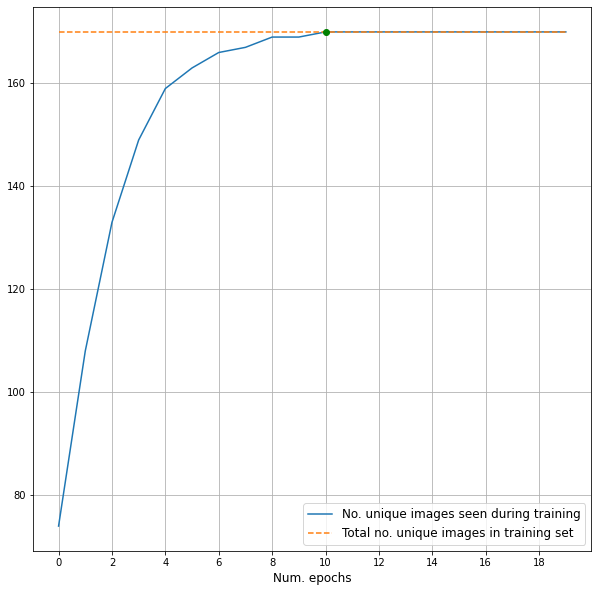

In [40]:
num_epochs = 20

unique_idxs_seen = set()
cumulative_unique_images_per_epoch = {}

for i in range(num_epochs):
    class_0_batch_counts, class_1_batch_counts, idxs_seen = visualise_dataloader(
        dl, with_outputs=False
    )
    unique_idxs_seen.update(idxs_seen)
    cumulative_unique_images_per_epoch[i] = len(unique_idxs_seen)

target_epoch = list(cumulative_unique_images_per_epoch.values()).index(len(ds))

fig, ax = plt.subplots(1, figsize=(10, 10))

ax.plot(
    cumulative_unique_images_per_epoch.keys(),
    cumulative_unique_images_per_epoch.values(),
    label="No. unique images seen during training",
)
ax.plot(
    cumulative_unique_images_per_epoch.keys(),
    [len(ds)] * len(cumulative_unique_images_per_epoch),
    label="Total no. unique images in training set",
    linestyle="--",
)

ax.plot(target_epoch, len(ds), "go")
ax.legend(fontsize=12)
ax.set_xlabel("Num. epochs", fontsize=12)
ax.grid()

ax.set_xticks(
    np.arange(20, step=2),
)
fig.show()


Here, we can see that it took 10 epochs until all images were seen at least once. However, as this is dependent on probability, there is a high likelihood that this number will change!

To get a more robust estimate, let's take inspiration from Monte Carlo methods and run this experiment multiple times and observe the distribution. To make this easier to interpret, we can represent this as a kernel density estimate plot.

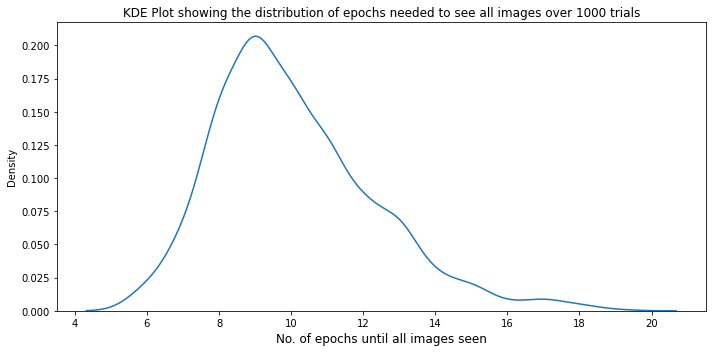

In [41]:
num_trials = 1000
num_epochs_needed = []

for t in range(num_trials):
    unique_idxs_seen = set()
    for i in range(num_epochs):
        class_0_batch_counts, class_1_batch_counts, idxs_seen = visualise_dataloader(dl, with_outputs=False)
        unique_idxs_seen.update(idxs_seen)
        if len(unique_idxs_seen) == len(ds):
            num_epochs_needed.append(i)
            break
            
fig, ax = plt.subplots(figsize=(10, 5))
sns.kdeplot(num_epochs_needed)
ax.set_xlabel('No. of epochs until all images seen', fontsize=12)
ax.set_title('KDE Plot showing the distribution of epochs needed to see all images over 1000 trials')
fig.tight_layout()
fig.show()

From this, we can see that, most of the time, around 9–10 epochs are necessary to be confident that all of the data will be seen.

Of course, this estimate highly depends on the proportion of imbalance in the underlying dataset. It seems logical to suggest that as the ratio of imbalance increases, more epochs will be needed. We can confirm this by repeating our trial for different levels of imbalance, as demonstrated below:

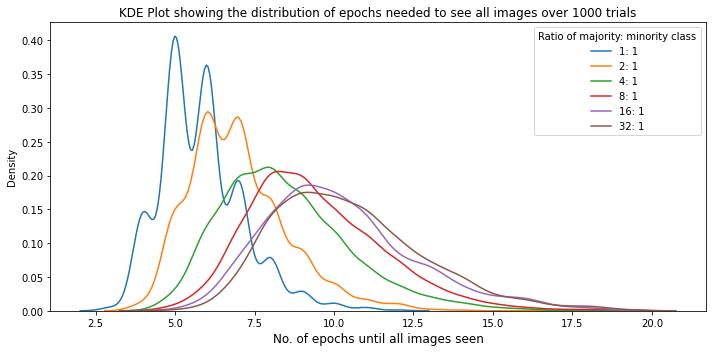

In [58]:
from collections import defaultdict


def run_trial_for_different_imalances(data_path, minority_class_counts, label_to_id):
    num_epochs_needed = defaultdict(list)
    for c in minority_class_counts:
        t_df, _ = create_dfs(data_path, "Siamese", "Birman", c)
        t_class_counts = t_df.label.value_counts()
        t_class_weights = [1 / t_class_counts[i] for i in t_df.label.values]
        t_ds = TensorDataset(
            torch.as_tensor([(idx, label_to_id[l]) for idx, l in enumerate(t_df.label.values)])
        )
        t_sampler = WeightedRandomSampler(
            weights=t_class_weights, num_samples=len(t_ds), replacement=True
        )
        t_dl = DataLoader(t_ds, sampler=t_sampler, batch_size=5)

        num_trials = 1000
        for t in range(num_trials):
            unique_idxs_seen = set()
            for i in range(num_epochs):
                _, _, idxs_seen = visualise_dataloader(t_dl, with_outputs=False)
                unique_idxs_seen.update(idxs_seen)
                if len(unique_idxs_seen) == len(t_ds):
                    num_epochs_needed[c].append(i)
                    break

    return num_epochs_needed


num_majority_class = imbalanced_train_df.label.value_counts()["Siamese"]

num_epochs_needed = run_trial(
    data_path,
    [
        int(num_majority_class),
        int(num_majority_class / 2),
        int(num_majority_class / 4),
        int(num_majority_class / 8),
        int(num_majority_class / 16),
        int(num_majority_class / 32),
    ],
    label_to_id,
)

fig, ax = plt.subplots(figsize=(10, 5))
for num_items, frequencies in num_epochs_needed.items():
    sns.kdeplot(frequencies, ax=ax, label=f"{int(num_majority_class / num_items)}: 1")
ax.legend(title="Ratio of majority: minority class")
ax.set_xlabel("No. of epochs until all images seen", fontsize=12)
ax.set_title(
    "KDE Plot showing the distribution of epochs needed to see all images over 1000 trials"
)
fig.tight_layout()
fig.show()


From the plot, we can observe that our intuition was correct. However, it is interesting to note that when using WeightedRandomSampler on a balanced dataset, it takes around 5 epochs to see all of the data; which suggests that this is not ideal in this case!

## Obtaining non-balanced dataset proportions

Now that we have explored how we can use WeightedRandomSampler to balance our training set, let's briefly examine how we can adjust our class weights to achieve any proportion that we would like. 

One example of where this may be useful is in object detection, where we would like most of our training to be focused on images containing the item that we wish to detect, but the available datasets often contain a high number of background images.
As an example, let's investigate how we can heavily imbalance the dataset the other way; such that our minority class becomes dominant.

Once again, first we need to calculate the total number of samples for each class:

In [268]:
class_counts = imbalanced_train_df.label.value_counts(); class_counts

Siamese    160
Birman      10
Name: label, dtype: int64

Now, lets define the target proportion for each class

In [98]:
target_proportions = {"Siamese": 0.1, "Birman": 0.9}

Finally, to calculate our sample weights, we simply have to multiply our weight by our target proportion, as demonstrated below:

In [99]:
sample_weights = [(target_proportions[i])*1/class_counts[i] for i in imbalanced_train_df.label.values]

As before, lets pass these weights into our sampler and visualise our batches.

In [100]:
sampler= WeightedRandomSampler(weights=sample_weights, num_samples=len(ds))
dl = DataLoader(ds, sampler=sampler, batch_size=10)

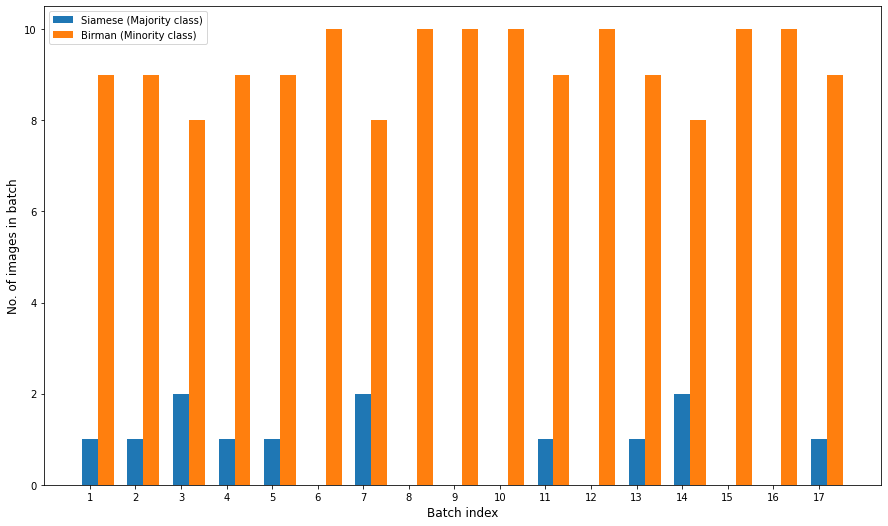

Avg Proportion of Siamese (Majority class) per batch: 0.07647058823529414
Avg Proportion of Birman (Minority class) per batch: 0.9235294117647059
Num. unique images seen: 21/170


In [101]:
_ = visualise_dataloader(dl,
                         {0: "Siamese (Majority class)", 
                          1: "Birman (Minority class)"})

From this, we can see that we have obtained the distribution that we are looking for.

## Does oversampling improve performance?

Hopefully, at this point, we have developed an intuition behind how WeightedRandomSampler works. However, you may be thinking, does simply showing the same image to the network more frequently really make a difference? Let's set up a small experiment to investigate.

Let's train an image classifier on our imbalanced dataset. Of course, the results will heavily depend on many factors - such as the model and dataset used - but this is designed as a simple example. Here, I have selected the following based on training recipes that have consistently worked well for me in the past:

- Model: ResNet-RS50
- Optimizer: AdamW
- LR scheduler: Cosine decay
- Images resized to 224

As our dataset is quite small, to simplify things further, lets only train the final linear layer used for classification in our architecture; as our images are very similar to the ImageNet images that the model has been pretrained on, it should be safe to assume that the features learned in the backbone should work well enough here.
To evaluate, we can the validation set we created earlier, which contains a balanced sample of images that were not seen during training.

In [59]:
val_df.label.value_counts()

Birman     40
Siamese    40
Name: label, dtype: int64

### Create script

We can define a script to conduct this experiment, as seen below:

In [293]:
%%writefile script.py

from pathlib import Path

import pandas as pd
import torch
import torchmetrics
from PIL import Image
from func_to_script import script
from pytorch_accelerated.callbacks import (
    TrainerCallback,
    SaveBestModelCallback,
    get_default_callbacks,
)
from pytorch_accelerated.finetuning import ModelFreezer
from pytorch_accelerated.schedulers import CosineLrScheduler
from pytorch_accelerated.trainer import (
    Trainer,
)
from sklearn.model_selection import train_test_split
from timm import create_model
from timm.data import create_transform
from torch import nn
from torch.utils.data import Dataset, WeightedRandomSampler


def create_dfs(data_path, majority_class_name, minority_class_name, num_minority_class):
    data_path = Path(data_path)
    images = []
    labels = []

    for p in data_path.glob("*.jpg"):
        image_name = p.parts[-1]
        images.append(image_name)
        labels.append("_".join(image_name.split("_")[0:-1]))

    df = pd.DataFrame(data={"image": images, "label": labels})
    sample_df = df.query(f'label == "{majority_class_name}" or label == "{minority_class_name}"')
    train_df, val_df = train_test_split(
        sample_df, stratify=sample_df.label, train_size=0.8, random_state=42
    )
    keep_images = set(
        train_df.query(f'label == "{minority_class_name}"').image.head(num_minority_class).tolist()
    )
    imbalanced_train_df = train_df[
        (train_df.image.isin(keep_images)) | (train_df.label == f"{majority_class_name}")
    ]

    return imbalanced_train_df, val_df


class PetsDataset(Dataset):
    def __init__(
        self,
        df,
        label_to_id,
        image_path=None,
        image_transforms=None,
    ):
        self.df = df
        self.image_path = Path(image_path) if image_path is not None else None
        self.image_transforms = image_transforms
        self.label_to_id = label_to_id
        self.id_to_label = {v: k for k, v in self.label_to_id.items()}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        data = self.df.iloc[idx]
        image_path = data.image

        if self.image_path is not None:
            image_path = self.image_path / image_path

        raw_image = Image.open(image_path)
        image = raw_image.convert("RGB")

        if self.image_transforms is not None:
            image = self.image_transforms(image)

        raw_label = data.label
        label = self.label_to_id[raw_label]

        return image, label


class ClassificationMetricsCallback(TrainerCallback):
    def __init__(self, num_classes):
        self.metrics = torchmetrics.MetricCollection(
            {
                "accuracy": torchmetrics.Accuracy(num_classes=num_classes),
                "precision": torchmetrics.Precision(num_classes=num_classes, average=None),
                "recall": torchmetrics.Recall(num_classes=num_classes, average=None),
                "cm": torchmetrics.ConfusionMatrix(num_classes=num_classes),
                "f1": torchmetrics.F1Score(num_classes=num_classes, average="weighted"),
            }
        )

    def _move_to_device(self, trainer):
        self.metrics.to(trainer.device)

    def on_training_run_start(self, trainer, **kwargs):
        self._move_to_device(trainer)

    def on_evaluation_run_start(self, trainer, **kwargs):
        self._move_to_device(trainer)

    def on_eval_step_end(self, trainer, batch, batch_output, **kwargs):
        preds = batch_output["model_outputs"].argmax(dim=-1)
        self.metrics.update(preds, batch[1])

    def on_eval_epoch_end(self, trainer, **kwargs):
        metrics = self.metrics.compute()
        trainer.run_history.update_metric("accuracy", metrics["accuracy"].cpu())
        trainer.run_history.update_metric("precision", metrics["precision"].cpu())
        trainer.run_history.update_metric("recall", metrics["recall"].cpu())
        trainer.run_history.update_metric("cm", metrics["cm"].cpu())
        trainer.run_history.update_metric("f1", metrics["f1"].cpu())
        self.metrics.reset()


@script
def main(
    data_path: str,
    num_epochs: int,
    lr: float = 0.01,
    batch_size: int = 8,
    oversample: bool = False,
    num_minority_class: int = 10,
    minority_class_name: str = "Birman",
    majority_class_name: str = "Siamese",
    with_augmentation: bool = False,
):
    data_path = Path(data_path)
    
    # Load data
    imbalanced_train_df, val_df = create_dfs(
        data_path,
        num_minority_class=num_minority_class,
        minority_class_name=minority_class_name,
        majority_class_name=majority_class_name,
    )
    label_to_id = {v: idx for idx, v in enumerate(imbalanced_train_df.label.unique())}
    num_classes = len(label_to_id)

    print(imbalanced_train_df.label.value_counts())
    print(val_df.label.value_counts())
    print(label_to_id)

    # calculate class and sample weights
    class_counts = imbalanced_train_df.label.value_counts()
    class_weights = 1 / class_counts
    sample_weights = [class_weights[i] for i in imbalanced_train_df.label.values]
    print(class_weights)

    # Create model (from timm)
    model = create_model(
        "resnetrs50",
        pretrained=True,
        num_classes=num_classes,
    )
    
    # select augmentations
    if with_augmentation:
        train_transform = create_transform(224, is_training=True)
    else:
        train_transform = create_transform(224)

    # Create datasets
    train_dataset = PetsDataset(imbalanced_train_df, label_to_id, data_path, train_transform)
    eval_dataset = PetsDataset(val_df, label_to_id, data_path, create_transform(224))

    # If oversampling, add this to DataLoader
    train_dl_kwargs = (
        {
            "sampler": WeightedRandomSampler(
                weights=sample_weights,
                num_samples=len(train_dataset),
            )
        }
        if oversample
        else None
    )

    # Define loss function
    loss_func = nn.CrossEntropyLoss()
    
    # Freeze model backbone
    freezer = ModelFreezer(model, freeze_batch_norms=False)
    freezer.freeze()

    # Define optimizer
    optimizer = torch.optim.AdamW(freezer.get_trainable_parameters(), lr=lr)

    trainer = Trainer(
        model=model,
        loss_func=loss_func,
        optimizer=optimizer,
        callbacks=[
            ClassificationMetricsCallback(num_classes=num_classes),
            *get_default_callbacks(progress_bar=True),
            SaveBestModelCallback(watch_metric="f1", greater_is_better=True),
        ],
    )

    trainer.train(
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        num_epochs=num_epochs,
        per_device_batch_size=batch_size,
        create_scheduler_fn=CosineLrScheduler.create_scheduler_fn(num_warmup_epochs=1),
        train_dataloader_kwargs=train_dl_kwargs,
    )


if __name__ == "__main__":
    main()


Overwriting script.py


In [ ]:
func-to-script==0.1.0
timm==0.6.7
torch==1.12.1
torchmetrics==0.9.3
torchvision==0.13.1
pytorch-accelerated==0.1.37

Selecting the best metrics after training for 10 epochs, by running the commands:

In [294]:
!python script.py --data_path data/pets/images --num_epochs 10

INFO:pytorch_accelerated:Setting random seeds
Siamese    160
Birman      10
Name: label, dtype: int64
Birman     40
Siamese    40
Name: label, dtype: int64
{'Siamese': 0, 'Birman': 1}
Siamese    0.0625
Birman     1.0000
Name: label, dtype: float64
INFO:timm.models.helpers:Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rs-weights/resnetrs50_ema-6b53758b.pth)

Starting training run

Starting epoch 1
100%|███████████████████████████████████████████| 22/22 [00:01<00:00, 14.02it/s]

train_loss_epoch: 0.5203642756029667
100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 20.11it/s]

eval_loss_epoch: 3.5295129776000977

cm: tensor([[40,  0],
        [40,  0]])

accuracy: 0.5

f1: 0.3333333432674408

precision: tensor([0.5000, 0.0000])

recall: tensor([1., 0.])

Starting epoch 2
100%|███████████████████████████████████████████| 22/22 [00:01<00:00, 17.13it/s]

train_loss_epoch: 0.23668353827678776
100%|████████████

In [295]:
!python script.py --data_path data/pets/images --num_epochs 10  --oversample True

INFO:pytorch_accelerated:Setting random seeds
Siamese    160
Birman      10
Name: label, dtype: int64
Birman     40
Siamese    40
Name: label, dtype: int64
{'Siamese': 0, 'Birman': 1}
Siamese    0.0625
Birman     1.0000
Name: label, dtype: float64
INFO:timm.models.helpers:Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rs-weights/resnetrs50_ema-6b53758b.pth)

Starting training run

Starting epoch 1
100%|███████████████████████████████████████████| 22/22 [00:01<00:00, 13.64it/s]

train_loss_epoch: 0.4795663234339479
100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 19.55it/s]

f1: 0.8465472459793091

precision: tensor([0.7692, 1.0000])

eval_loss_epoch: 0.4370653495192528

cm: tensor([[40,  0],
        [12, 28]])

accuracy: 0.8500000238418579

recall: tensor([1.0000, 0.7000])

Starting epoch 2
100%|███████████████████████████████████████████| 22/22 [00:01<00:00, 16.41it/s]

train_loss_epoch: 0.163548935238

Oh no, this looks like oversampling actually made things worse! 
However, with the way that our experiment is set up, this is not hugely surprising, as we are restricting the model's exposure to new images from the majority class in favour of repeatedly showing a small number of images from the minority class. If only there was a way to get more out of the small set of Birman images…

### Adding Data Augmentation

To try and help the model learn more from our images, we can use data augmentation to generate slightly modified versions of each image during training.

In this case, I decided to use the predefined RandAugment policy from timm, as this requires minimal hyperparameter tuning; timm's RandAugment implementation is described in [detail here](https://towardsdatascience.com/getting-started-with-pytorch-image-models-timm-a-practitioners-guide-4e77b4bf9055#8549).

In [49]:
image = Image.open(data_path/imbalanced_train_df.iloc[0].image)

In [52]:
from timm.data.auto_augment import rand_augment_transform

tfm = rand_augment_transform(
    config_str='rand-m9-mstd0.5', 
    hparams={}
)

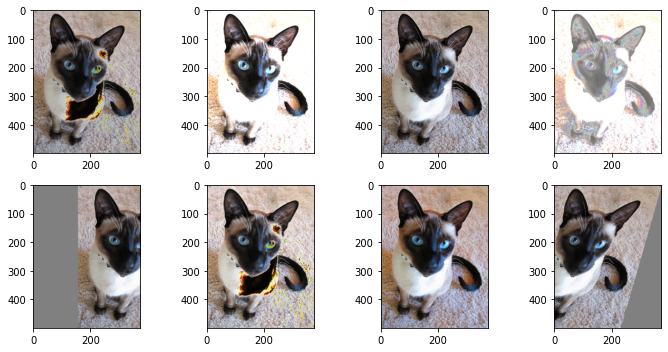

In [57]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 4, figsize=(10, 5))

for idx, im in enumerate([tfm(image) for i in range(4)]):
    ax[0, idx].imshow(im)
    
for idx, im in enumerate([tfm(image) for i in range(4)]):
    ax[1, idx].imshow(im)

fig.tight_layout()
plt.show()

Let's run the experiment again, this time with data augmentation:

In [296]:
!python script.py --data_path data/pets/images --num_epochs 10 --with_augmentation True

INFO:pytorch_accelerated:Setting random seeds
Siamese    160
Birman      10
Name: label, dtype: int64
Birman     40
Siamese    40
Name: label, dtype: int64
{'Siamese': 0, 'Birman': 1}
Siamese    0.0625
Birman     1.0000
Name: label, dtype: float64
INFO:timm.models.helpers:Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rs-weights/resnetrs50_ema-6b53758b.pth)

Starting training run

Starting epoch 1
100%|███████████████████████████████████████████| 22/22 [00:01<00:00, 13.89it/s]

train_loss_epoch: 0.5263773935333963
100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 18.06it/s]

f1: 0.3333333432674408

eval_loss_epoch: 2.660576915740967

recall: tensor([1., 0.])

precision: tensor([0.5000, 0.0000])

cm: tensor([[40,  0],
        [40,  0]])

accuracy: 0.5

Starting epoch 2
100%|███████████████████████████████████████████| 22/22 [00:01<00:00, 16.45it/s]

train_loss_epoch: 0.3201347444829641
100%|██████████████

In [297]:
!python script.py --data_path data/pets/images --num_epochs 10 --oversample True --with_augmentation True

INFO:pytorch_accelerated:Setting random seeds
Siamese    160
Birman      10
Name: label, dtype: int64
Birman     40
Siamese    40
Name: label, dtype: int64
{'Siamese': 0, 'Birman': 1}
Siamese    0.0625
Birman     1.0000
Name: label, dtype: float64
INFO:timm.models.helpers:Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rs-weights/resnetrs50_ema-6b53758b.pth)

Starting training run

Starting epoch 1
100%|███████████████████████████████████████████| 22/22 [00:01<00:00, 13.43it/s]

train_loss_epoch: 0.5767909581170363
100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 20.07it/s]

recall: tensor([1.0000, 0.6500])

eval_loss_epoch: 0.417803368717432

f1: 0.8194712400436401

accuracy: 0.824999988079071

cm: tensor([[40,  0],
        [14, 26]])

precision: tensor([0.7407, 1.0000])

Starting epoch 2
100%|███████████████████████████████████████████| 22/22 [00:01<00:00, 16.09it/s]

train_loss_epoch: 0.23901297213400

This time, we can see that the combination of data augmentation and oversampling resulted in a significant increase in performance!

## Conclusion

Hopefully that has provided a somewhat comprehensive overview of how to get started with WeightedRandomSampler, and helped to illustrate how it can be used.

Oxford Pets Dataset, Visual Geometry Group - University of Oxford. Creative Commons Attribution-ShareAlike 4.0 International License, including commercial and research purposes.